In [40]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
# Load the data
df = pd.read_csv('input_data/Multi-Year Price Data (Aggregate).csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head(10)

Dataset Shape: (1476, 2)

First few rows:


,Date,Price
0,1/1/2012,99
1,1/2/2012,95
2,1/3/2012,96
3,1/4/2012,95
4,1/5/2012,93
5,1/6/2012,93
6,1/7/2012,95
7,1/8/2012,96
8,1/9/2012,98
9,1/10/2012,98


In [13]:
# Basic info
print("Dataset Info:")
print("="*50)
df.info()

print("\n" + "="*50)
print("Basic Statistics:")
print("="*50)
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1476 non-null   object
 1   Price   1476 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.2+ KB

Basic Statistics:


,Price
count,1476.000000
mean,114.102981
std,20.482524
min,81.000000
25%,99.000000
50%,111.500000
75%,124.000000
max,281.000000


In [14]:
# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print("Date Range:")
print(f"Start Date: {df['Date'].min()}")
print(f"End Date: {df['Date'].max()}")
print(f"Total Days: {len(df)}")
print(f"Duration: {(df['Date'].max() - df['Date'].min()).days} days")

Date Range:
Start Date: 2012-01-01 00:00:00
End Date: 2016-01-16 00:00:00
Total Days: 1476
Duration: 1476 days


# Data quality assessment

In [15]:
# Check for missing values
print("Missing Values:")
print("="*50)
print(df.isnull().sum())

# Check for duplicates
print("\nDuplicate Dates:")
print("="*50)
duplicates = df[df.duplicated(subset=['Date'], keep=False)]
if len(duplicates) > 0:
    print(duplicates)
else:
    print("No duplicate dates found")

Missing Values:
Date     0
Price    0
dtype: int64

Duplicate Dates:
No duplicate dates found


In [16]:
# Check for missing dates (gaps in the time series)
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
missing_dates = date_range.difference(df['Date'])

print(f"Expected days in range: {len(date_range)}")
print(f"Actual days in data: {len(df)}")
print(f"Missing days: {len(missing_dates)}")

if len(missing_dates) > 0:
    print("\nMissing dates:")
    for date in missing_dates:
        print(f"  {date.date()}")

Expected days in range: 1477
Actual days in data: 1476
Missing days: 1

Missing dates:
  2012-07-13


In [17]:
# Check for outliers in Price
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]

print(f"Outlier Detection (IQR method):")
print(f"Lower Bound: {lower_bound:.2f}")
print(f"Upper Bound: {upper_bound:.2f}")
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

if len(outliers) > 0: 
    print("\nTop 10 outliers:")
    print(outliers.nlargest(10, 'Price')[['Date', 'Price']])

Outlier Detection (IQR method):
Lower Bound: 61.50
Upper Bound: 161.50
Number of outliers: 46 (3.12%)

Top 10 outliers:
           Date  Price
1166 2015-03-13    281
1165 2015-03-12    193
1180 2015-03-27    192
1173 2015-03-20    191
1159 2015-03-06    190
1172 2015-03-19    190
1179 2015-03-26    189
1167 2015-03-14    188
1171 2015-03-18    188
1178 2015-03-25    188


# Pattern Analysis

In [18]:
# Create temporal features for analysis
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.month_name()
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfWeek_Name'] = df['Date'].dt.day_name()
df['Quarter'] = df['Date'].dt.quarter
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfYear'] = df['Date'].dt.dayofyear

print("Temporal features created!")
df.head(10)

Temporal features created!


,Date,Price,Year,Month,Month_Name,Day,DayOfWeek,DayOfWeek_Name,Quarter,Week,DayOfYear
0,2012-01-01,99,2012,1,January,1,6,Sunday,1,52,1
1,2012-01-02,95,2012,1,January,2,0,Monday,1,1,2
2,2012-01-03,96,2012,1,January,3,1,Tuesday,1,1,3
3,2012-01-04,95,2012,1,January,4,2,Wednesday,1,1,4
4,2012-01-05,93,2012,1,January,5,3,Thursday,1,1,5
5,2012-01-06,93,2012,1,January,6,4,Friday,1,1,6
6,2012-01-07,95,2012,1,January,7,5,Saturday,1,1,7
7,2012-01-08,96,2012,1,January,8,6,Sunday,1,1,8
8,2012-01-09,98,2012,1,January,9,0,Monday,1,2,9
9,2012-01-10,98,2012,1,January,10,1,Tuesday,1,2,10


In [ ]:
# Yearly trends
yearly_stats = df.groupby('Year')['Price'].agg(['mean', 'std', 'min', 'max', 'count']).round(2)
print("Yearly Statistics:")
print("="*70)
print(yearly_stats)

# Calculate year-over-year growth
yearly_mean = df.groupby('Year')['Price'].mean()
yoy_growth = yearly_mean.pct_change() * 100
print("\nYear-over-Year Growth (%)")
print("="*70) 
print(yoy_growth.round(2)) 

Yearly Statistics:
        mean    std  min  max  count
Year                                
2012   99.43  12.95   81  139    365
2013  104.61  13.40   86  157    365
2014  119.47  15.43   97  166    365
2015  131.84  20.84  101  281    365
2016  138.19  10.62  120  157     16

Year-over-Year Growth (%)
Year
2012      NaN
2013     5.21
2014    14.20
2015    10.36
2016     4.81
Name: Price, dtype: float64


In [20]:
# Monthly patterns
monthly_stats = df.groupby('Month')['Price'].agg(['mean', 'std', 'min', 'max']).round(2)
monthly_stats.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
print("Monthly Statistics (across all years):")
print("="*70)
print(monthly_stats)

# Find peak and low seasons
peak_month = monthly_stats['mean'].idxmax()
low_month = monthly_stats['mean'].idxmin()
print(f"\nPeak Season: {peak_month} (avg: ${monthly_stats.loc[peak_month, 'mean']:.2f})")
print(f"Low Season: {low_month} (avg: ${monthly_stats.loc[low_month, 'mean']:.2f})")
print(f"Seasonal Variation: ${monthly_stats['mean'].max() - monthly_stats['mean'].min():.2f}")

Monthly Statistics (across all years):
       mean    std  min  max
Jan  113.71  16.42   90  157
Feb  129.70  17.97  102  169
Mar  150.04  24.04  117  281
Apr  126.91  18.03   92  165
May  110.84  12.49   84  138
Jun  109.72  11.42   85  132
Jul  108.33  12.21   86  132
Aug  106.95  10.61   88  139
Sep  101.73  11.40   81  128
Oct  105.00  13.60   82  136
Nov  103.49  15.17   82  146
Dec  103.73  14.57   81  154

Peak Season: Mar (avg: $150.04)
Low Season: Sep (avg: $101.73)
Seasonal Variation: $48.31


In [21]:
# Day of week patterns
dow_stats = df.groupby('DayOfWeek_Name')['Price'].agg(['mean', 'std']).round(2)
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = dow_stats.reindex(dow_order)

print("Day of Week Statistics:")
print("="*70)
print(dow_stats)

# Weekend vs weekday
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
weekend_avg = df[df['IsWeekend']==1]['Price'].mean()
weekday_avg = df[df['IsWeekend']==0]['Price'].mean()

print(f"\nWeekend Average: ${weekend_avg:.2f}")
print(f"Weekday Average: ${weekday_avg:.2f}")
print(f"Weekend Premium: ${weekend_avg - weekday_avg:.2f} ({(weekend_avg/weekday_avg - 1)*100:.2f}%)")

Day of Week Statistics:
                  mean    std
DayOfWeek_Name               
Monday          113.49  19.20
Tuesday         113.70  19.69
Wednesday       114.17  20.56
Thursday        114.27  21.02
Friday          115.99  23.28
Saturday        114.64  21.07
Sunday          112.47  18.30

Weekend Average: $113.55
Weekday Average: $114.32
Weekend Premium: $-0.77 (-0.67%)


In [22]:
# Quarterly patterns
quarterly_stats = df.groupby('Quarter')['Price'].agg(['mean', 'std']).round(2)
print("Quarterly Statistics:")
print("="*70)
print(quarterly_stats)

Quarterly Statistics:
           mean    std
Quarter               
1        130.45  24.82
2        115.77  16.24
3        105.71  11.74
4        104.08  14.43


# Statistical analysis

In [23]:
# Overall price distribution
print("Price Distribution Statistics:")
print("="*70)
print(f"Mean: ${df['Price'].mean():.2f}")
print(f"Median: ${df['Price'].median():.2f}")
print(f"Mode: ${df['Price'].mode().values[0]:.2f}")
print(f"Standard Deviation: ${df['Price'].std():.2f}")
print(f"Variance: {df['Price'].var():.2f}")
print(f"Coefficient of Variation: {(df['Price'].std() / df['Price'].mean() * 100):.2f}%")
print(f"\nSkewness: {df['Price'].skew():.2f}")
print(f"Kurtosis: {df['Price'].kurtosis():.2f}")
print(f"\nRange: ${df['Price'].min():.2f} - ${df['Price'].max():.2f}")
print(f"IQR: ${Q3 - Q1:.2f}")

Price Distribution Statistics:
Mean: $114.10
Median: $111.50
Mode: $113.00
Standard Deviation: $20.48
Variance: 419.53
Coefficient of Variation: 17.95%

Skewness: 1.32
Kurtosis: 3.89

Range: $81.00 - $281.00
IQR: $25.00


In [26]:
# Calculate autocorrelation manually for different lags
from scipy.stats import pearsonr

lags = [1, 7, 14, 30, 365]
autocorr = {}

for lag in lags:
    if len(df) > lag:
        corr, _ = pearsonr(df['Price'][:-lag], df['Price'][lag:])
        autocorr[lag] = corr

print("Autocorrelation at different lags:")
print("="*70)
for lag, corr in autocorr.items():
    print(f"Lag {lag:3d} days: {corr:.4f}")

Autocorrelation at different lags:
Lag   1 days: 0.9404
Lag   7 days: 0.8941
Lag  14 days: 0.8443
Lag  30 days: 0.6797
Lag 365 days: 0.8702


In [27]:
# Calculate rolling statistics
df['Rolling_Mean_7'] = df['Price'].rolling(window=7, center=False).mean()
df['Rolling_Std_7'] = df['Price'].rolling(window=7, center=False).std()
df['Rolling_Mean_30'] = df['Price'].rolling(window=30, center=False).mean()
df['Rolling_Std_30'] = df['Price'].rolling(window=30, center=False).std()

print("Rolling statistics calculated!")
print("\nSample of rolling statistics:")
df[['Date', 'Price', 'Rolling_Mean_7', 'Rolling_Std_7', 'Rolling_Mean_30', 'Rolling_Std_30']].tail(10)

Rolling statistics calculated!

Sample of rolling statistics:


,Date,Price,Rolling_Mean_7,Rolling_Std_7,Rolling_Mean_30,Rolling_Std_30
1466,2016-01-07,130,134.428571,11.998016,125.133333,12.544358
1467,2016-01-08,127,130.142857,6.841749,125.266667,12.542159
1468,2016-01-09,133,129.428571,6.106203,125.733333,12.561389
1469,2016-01-10,130,130.857143,4.488079,125.833333,12.583742
1470,2016-01-11,139,133.000000,4.242641,126.200000,12.807325
1471,2016-01-12,147,134.571429,6.803361,127.133333,13.276199
1472,2016-01-13,150,136.571429,8.997354,128.466667,13.502831
1473,2016-01-14,148,139.142857,9.370674,129.666667,13.588366
1474,2016-01-15,149,142.285714,8.240435,130.866667,13.655196
1475,2016-01-16,147,144.285714,7.250616,132.033333,13.481746


# Visualizations

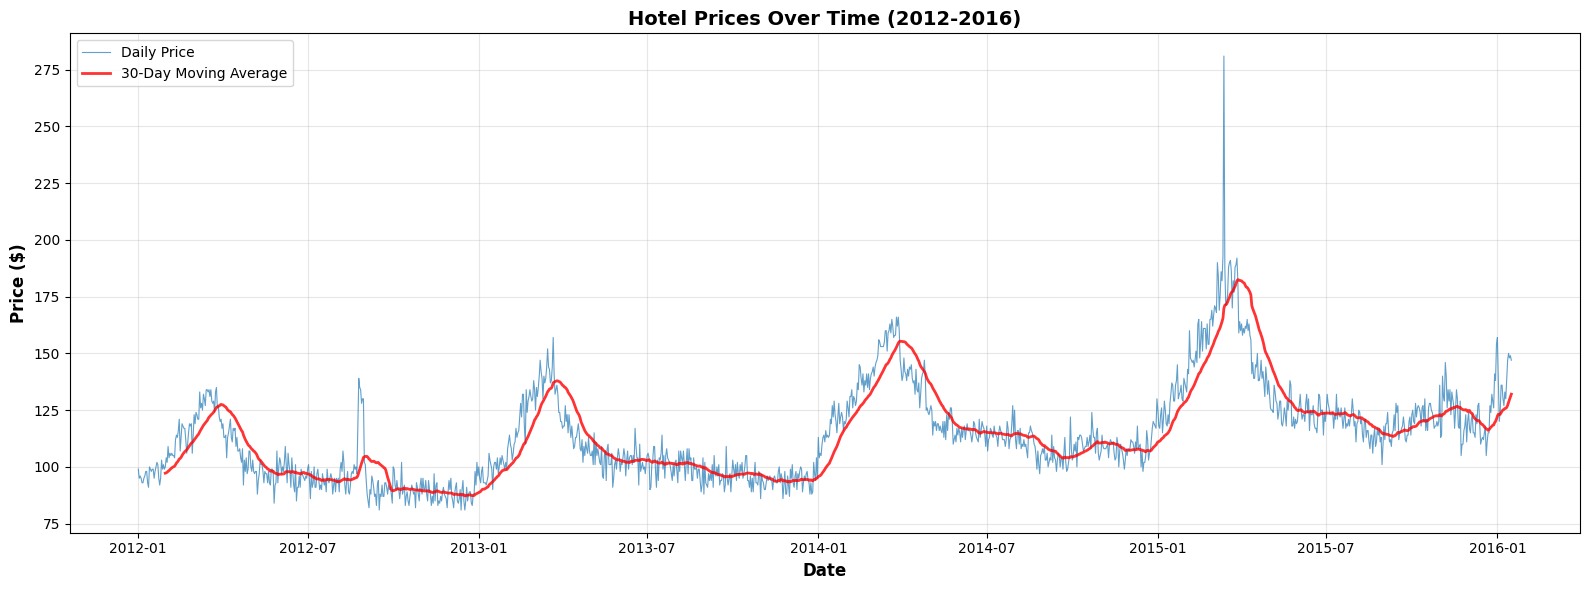

Overall trend: Strong upward trend visible from 2012 to 2016


In [30]:
# 1. Overall Time Series Plot
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df['Date'], df['Price'], linewidth=0.8, alpha=0.7, label='Daily Price')
ax.plot(df['Date'], df['Rolling_Mean_30'], linewidth=2, color='red', 
        label='30-Day Moving Average', alpha=0.8)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
ax.set_title('Hotel Prices Over Time (2012-2016)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Overall trend: Strong upward trend visible from 2012 to 2016")

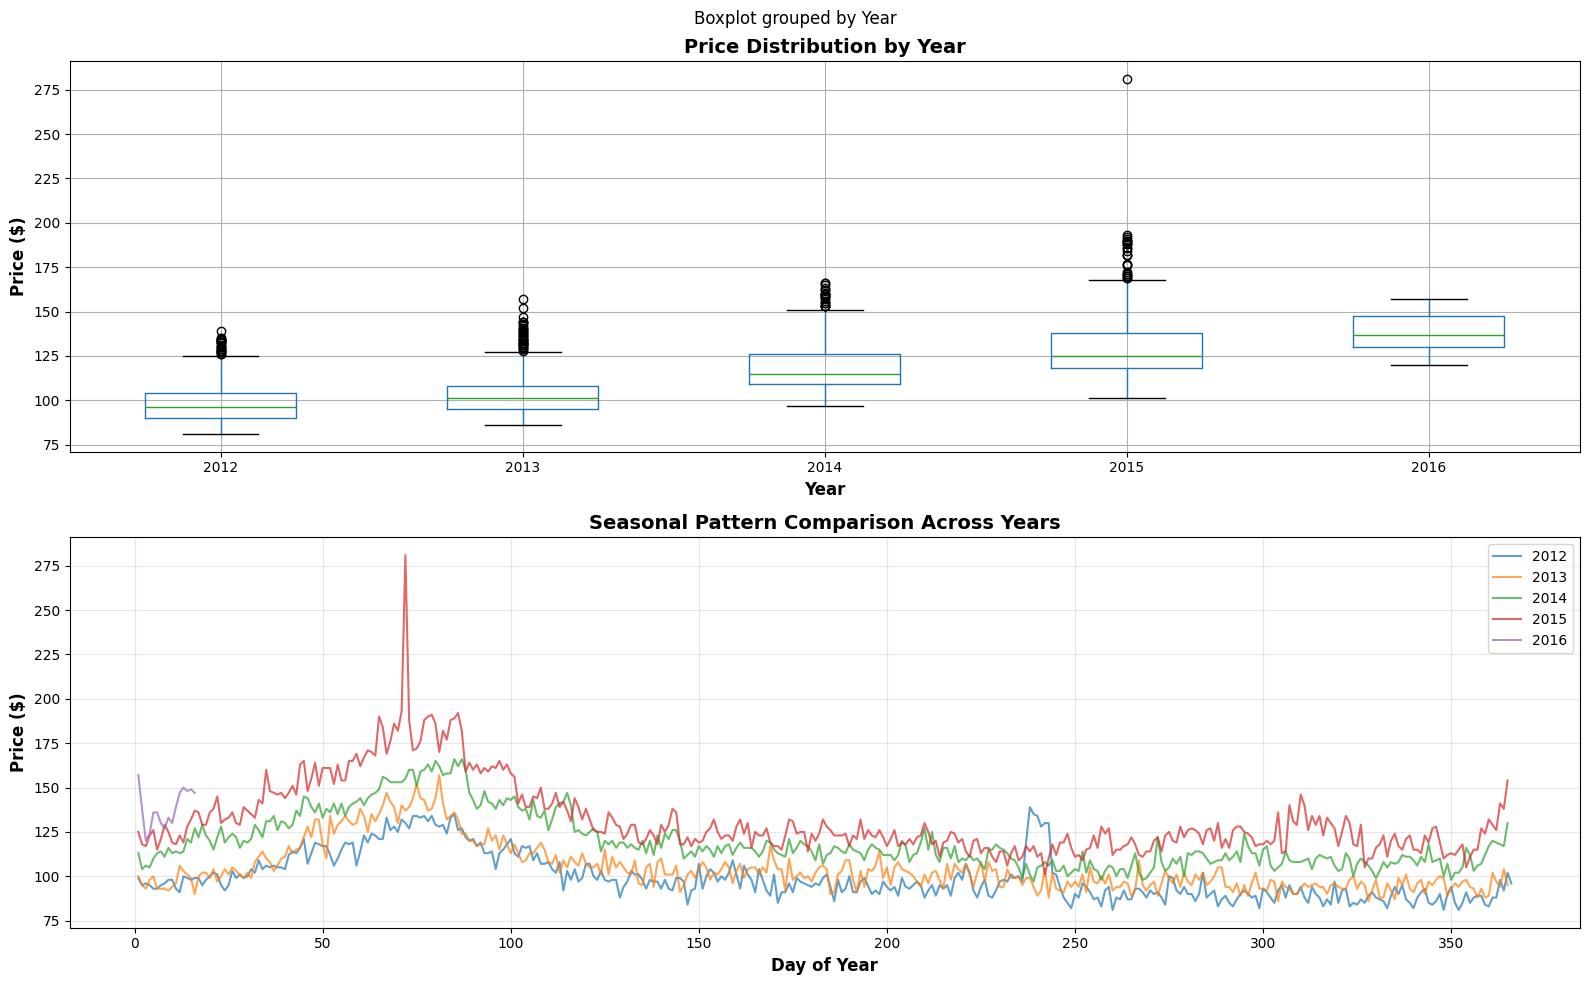

In [31]:
# 2. Yearly Comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Box plot
df.boxplot(column='Price', by='Year', ax=axes[0])
axes[0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Price Distribution by Year', fontsize=14, fontweight='bold')
plt.sca(axes[0])
plt.xticks(rotation=0)

# Line plot with individual years
for year in df['Year'].unique():
    year_data = df[df['Year'] == year].copy()
    year_data['DayOfYear'] = year_data['Date'].dt.dayofyear
    axes[1].plot(year_data['DayOfYear'], year_data['Price'], 
                 label=f'{year}', alpha=0.7, linewidth=1.5)

axes[1].set_xlabel('Day of Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Seasonal Pattern Comparison Across Years', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

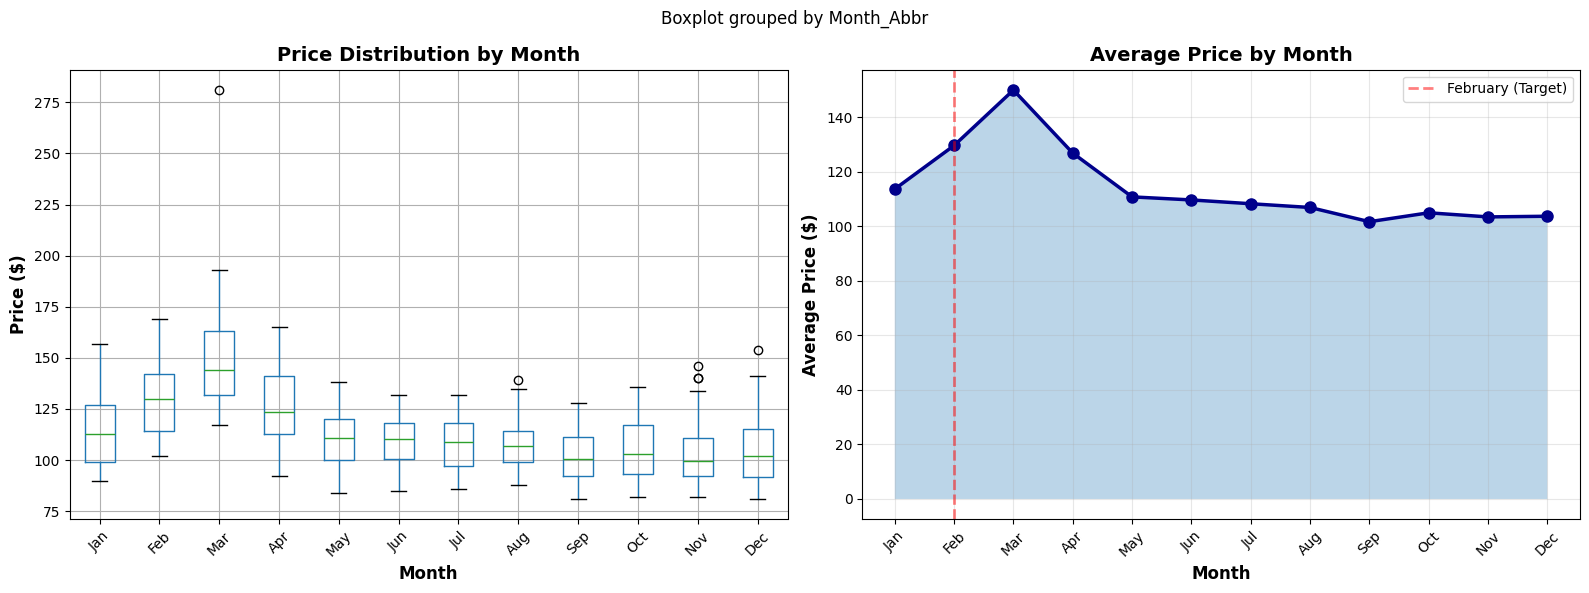


*** February (our target month) has an average price of $129.70 ***


In [32]:
# 3. Monthly Seasonality Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot by month
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month_Abbr'] = df['Date'].dt.month_name().str[:3]
df['Month_Abbr'] = pd.Categorical(df['Month_Abbr'], categories=month_order, ordered=True)

df.boxplot(column='Price', by='Month_Abbr', ax=axes[0])
axes[0].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Price Distribution by Month', fontsize=14, fontweight='bold')
plt.sca(axes[0])
plt.xticks(rotation=45)

# Monthly average line plot
monthly_avg = df.groupby('Month')['Price'].mean()
axes[1].plot(range(1, 13), monthly_avg.values, marker='o', 
             linewidth=2.5, markersize=8, color='darkblue')
axes[1].fill_between(range(1, 13), monthly_avg.values, alpha=0.3)
axes[1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Price ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Average Price by Month', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_order, rotation=45)
axes[1].grid(True, alpha=0.3)

# Highlight February
axes[1].axvline(x=2, color='red', linestyle='--', linewidth=2, alpha=0.5, label='February (Target)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n*** February (our target month) has an average price of ${monthly_avg[2]:.2f} ***")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26540\3644473942.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dow_avg = df.groupby('DayOfWeek_Name')['Price'].mean().reindex(dow_order)


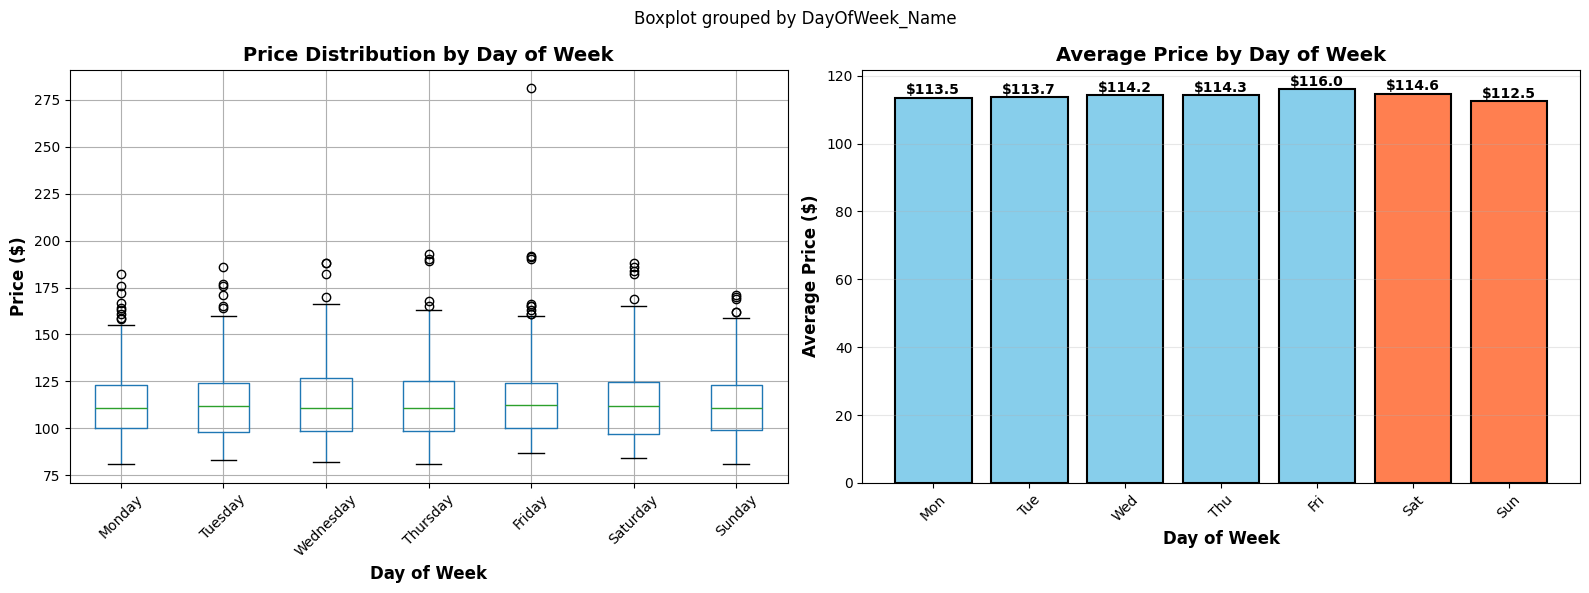

In [33]:
# 4. Day of Week Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayOfWeek_Name'] = pd.Categorical(df['DayOfWeek_Name'], categories=dow_order, ordered=True)

df.boxplot(column='Price', by='DayOfWeek_Name', ax=axes[0])
axes[0].set_xlabel('Day of Week', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Price Distribution by Day of Week', fontsize=14, fontweight='bold')
plt.sca(axes[0])
plt.xticks(rotation=45)

# Bar plot of averages
dow_avg = df.groupby('DayOfWeek_Name')['Price'].mean().reindex(dow_order)
colors = ['skyblue']*5 + ['coral', 'coral']  # Highlight weekends
axes[1].bar(range(7), dow_avg.values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Day of Week', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Price ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Average Price by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels([d[:3] for d in dow_order], rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(dow_avg.values):
    axes[1].text(i, v + 1, f'${v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

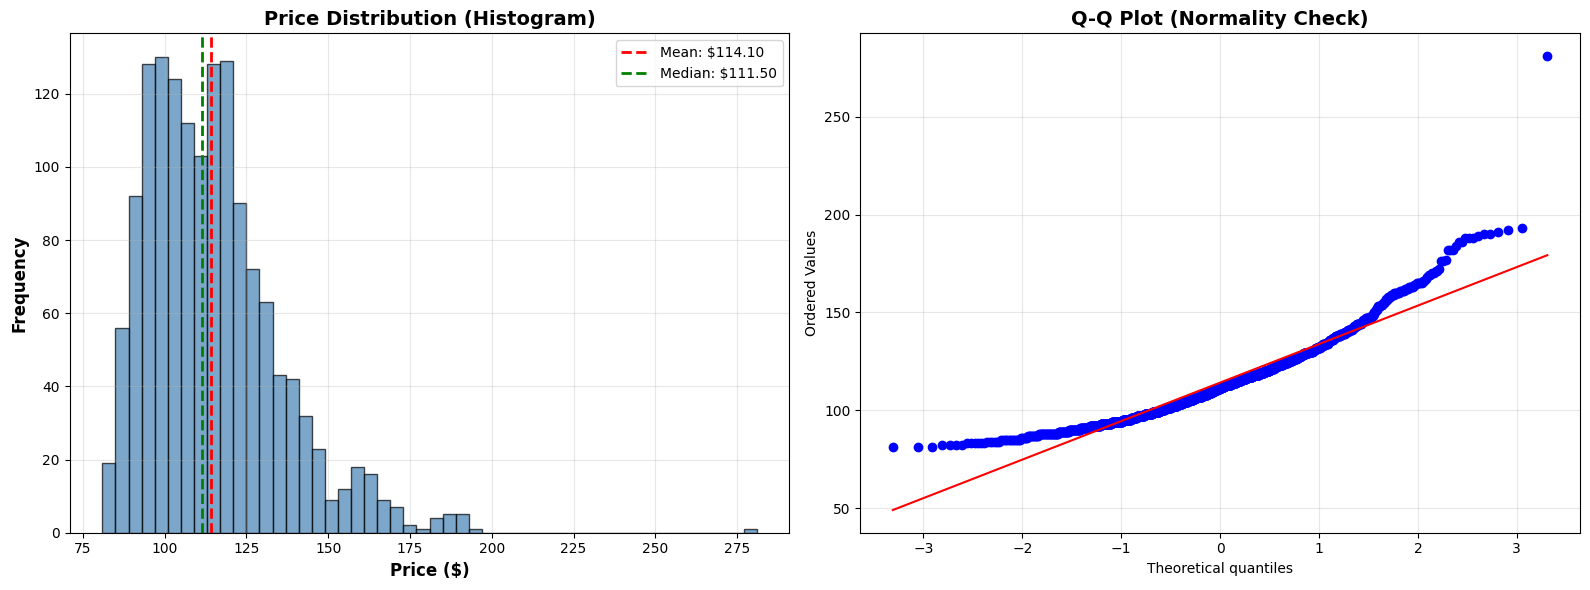

Distribution appears skewed


In [34]:
# 5. Price Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(df['Price'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df['Price'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: ${df["Price"].mean():.2f}')
axes[0].axvline(df['Price'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: ${df["Price"].median():.2f}')
axes[0].set_xlabel('Price ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Price Distribution (Histogram)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q plot for normality check
from scipy import stats
stats.probplot(df['Price'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Distribution appears {'approximately normal' if abs(df['Price'].skew()) < 0.5 else 'skewed'}")

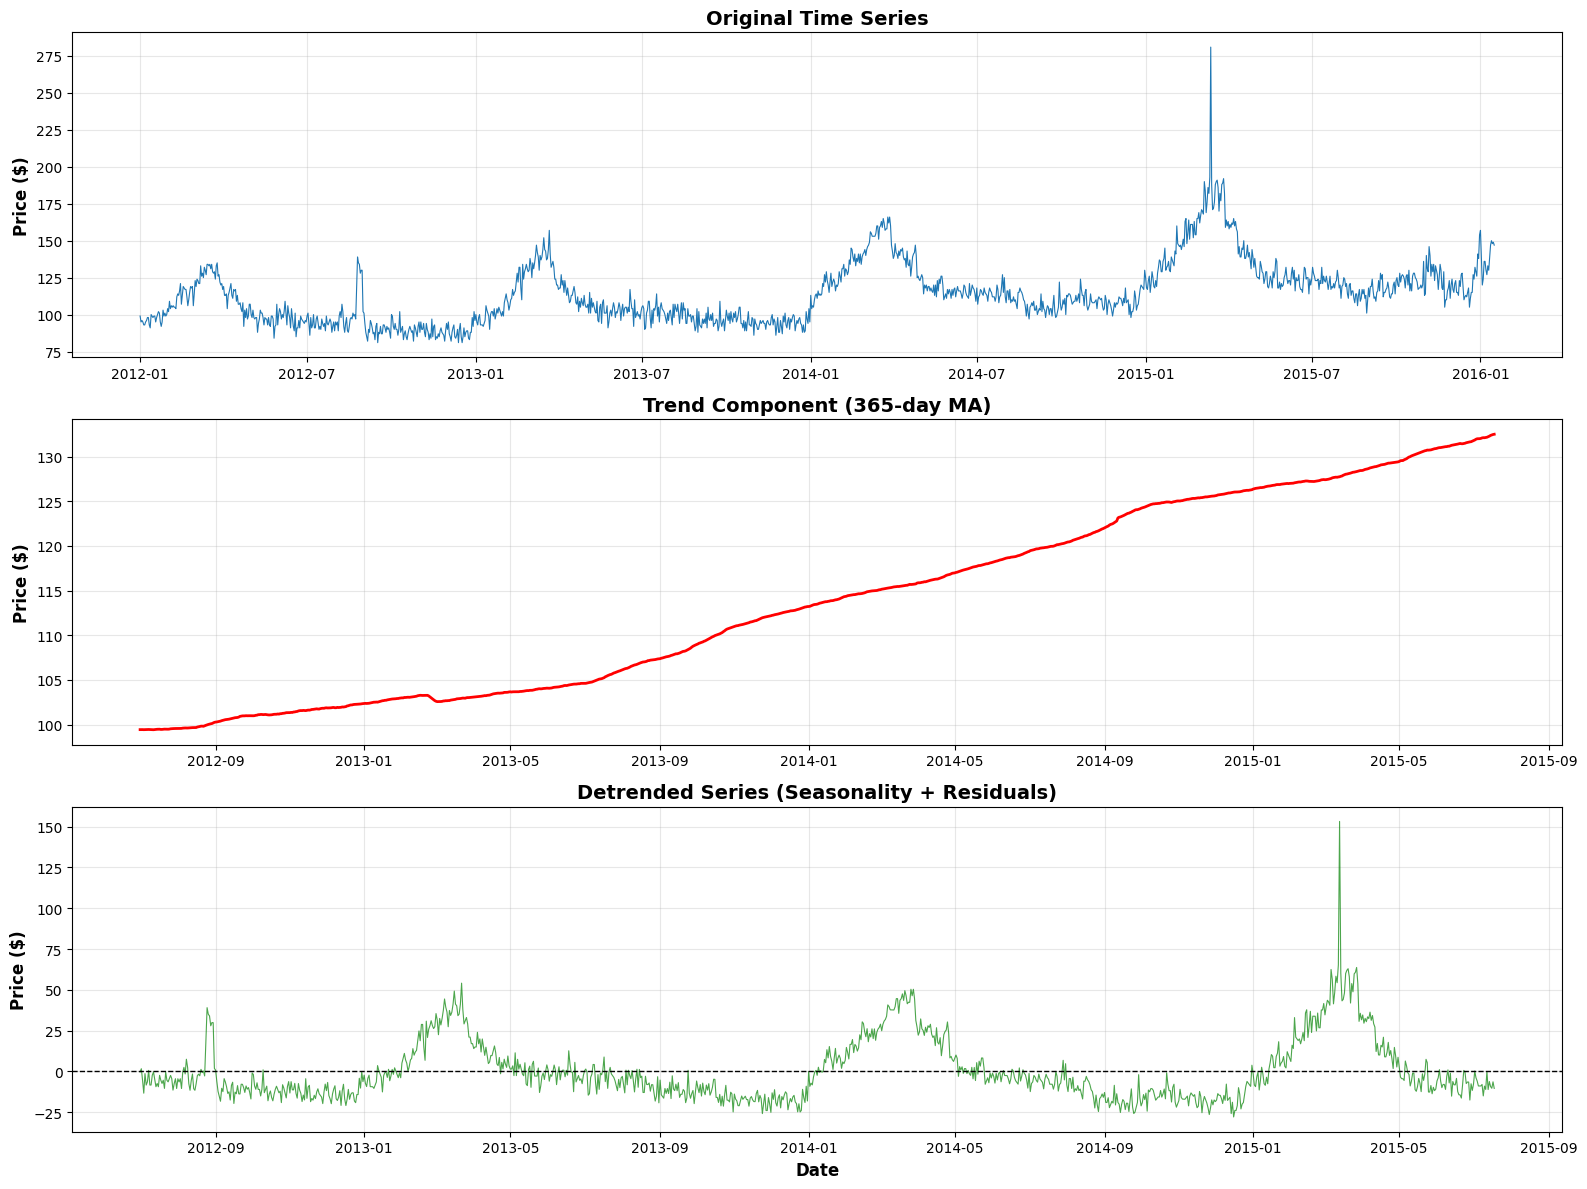

In [35]:
# 6. Trend Decomposition (Manual)
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Original series
axes[0].plot(df['Date'], df['Price'], linewidth=0.8)
axes[0].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Original Time Series', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend (using 365-day moving average)
trend = df['Price'].rolling(window=365, center=True).mean()
axes[1].plot(df['Date'], trend, linewidth=2, color='red')
axes[1].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Trend Component (365-day MA)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Detrended (Original - Trend)
detrended = df['Price'] - trend
axes[2].plot(df['Date'], detrended, linewidth=0.8, color='green', alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[2].set_title('Detrended Series (Seasonality + Residuals)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

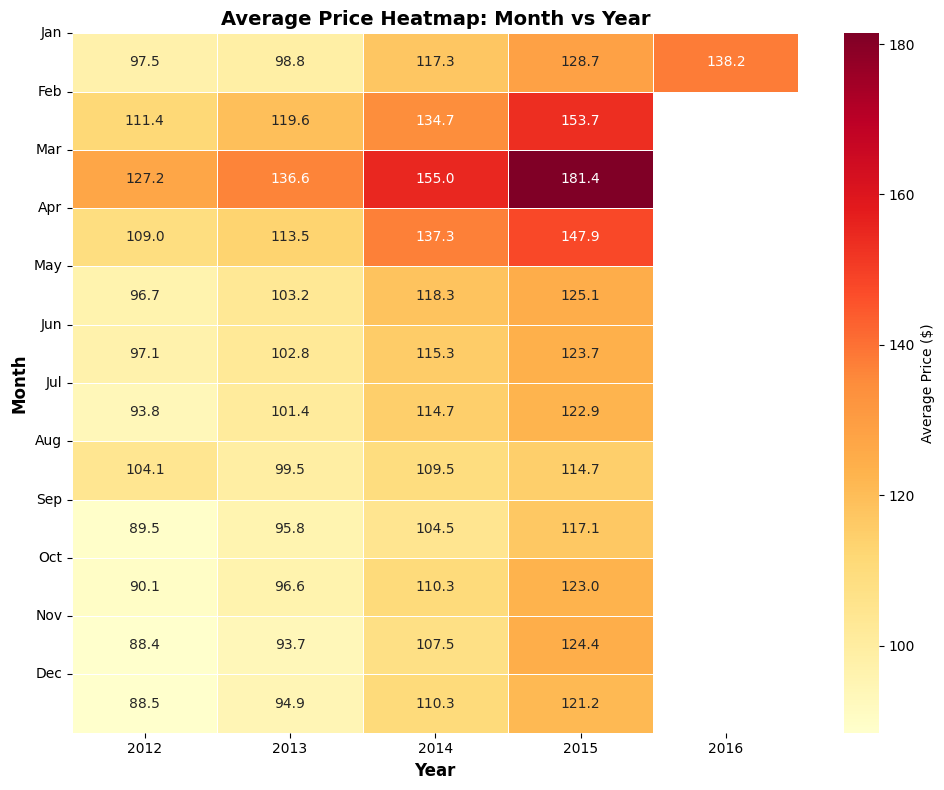


Key observation: February shows consistent high prices across all years!


In [38]:
# 7. Heatmap: Month vs Year
pivot_data = df.pivot_table(values='Price', index='Month', columns='Year', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Average Price ($)'})
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Month', fontsize=12, fontweight='bold')
plt.title('Average Price Heatmap: Month vs Year', fontsize=14, fontweight='bold')
plt.yticks(range(12), month_order, rotation=0)
plt.tight_layout()
plt.show()

print("\nKey observation: February shows consistent high prices across all years!")

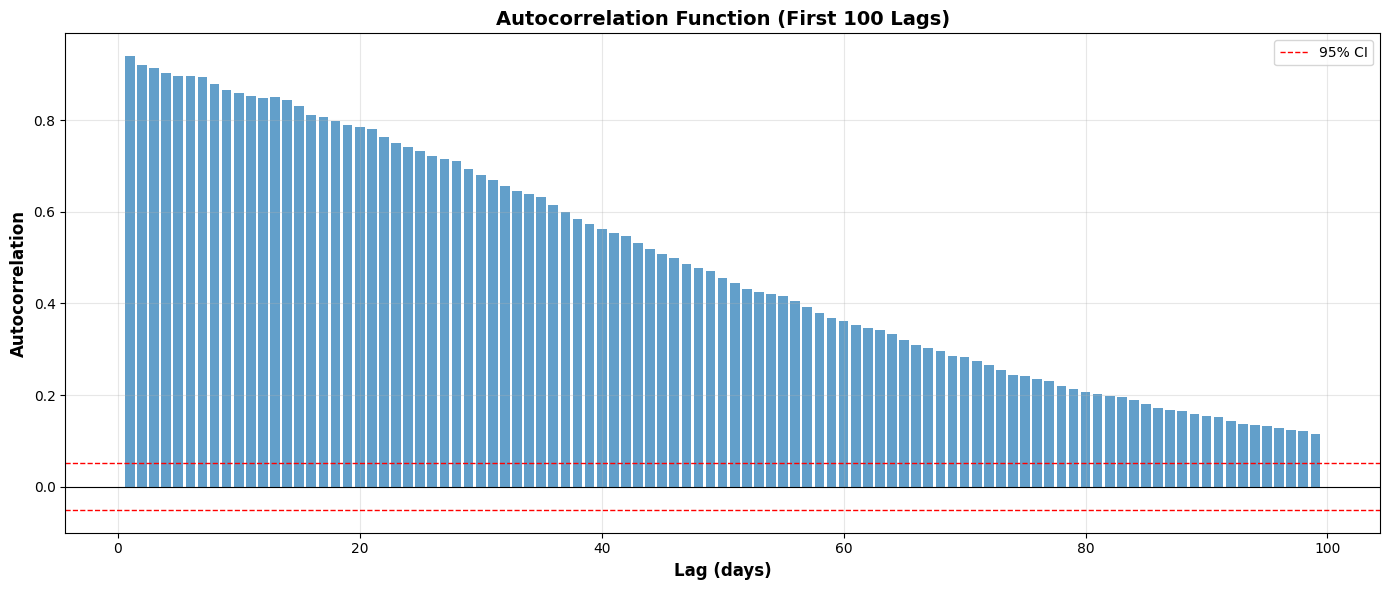

High autocorrelation at lag 365 would indicate strong yearly seasonality


In [41]:
# 8. Autocorrelation visualization
fig, ax = plt.subplots(figsize=(14, 6))

lags_to_plot = range(1, 100)
autocorr_values = []

for lag in lags_to_plot:
    if len(df) > lag:
        corr, _ = pearsonr(df['Price'][:-lag], df['Price'][lag:])
        autocorr_values.append(corr)

ax.bar(lags_to_plot, autocorr_values, width=0.8, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axhline(y=1.96/np.sqrt(len(df)), color='red', linestyle='--', linewidth=1, label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(df)), color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Lag (days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Autocorrelation', fontsize=12, fontweight='bold')
ax.set_title('Autocorrelation Function (First 100 Lags)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("High autocorrelation at lag 365 would indicate strong yearly seasonality")